![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 14 - Auto-encoders </center>
### <center> Denoising Auto-encoders </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/14_AutoEncoders/MainDenoisingAutoEncoder.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchinfo

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/14_AutoEncoders/DeepLearningFramework ./DeepLearningFramework

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath   = '../../data/'
oTrainSet_ = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=transforms.ToTensor(), download=True)
oTestSet_  = torchvision.datasets.MNIST(root=dataPath, train=False, transform=transforms.ToTensor(), download=True)

#### Dataset:

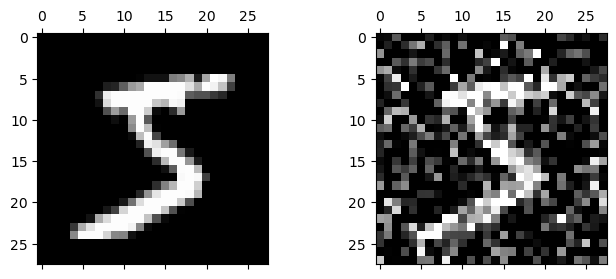

In [6]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    def __init__(self, oDataset, σ):
        self.oDataset = oDataset
        self.σ        = σ
        
    def __len__(self):
        return len(self.oDataset)
    
    def __getitem__(self, idx):
        mX, _ = self.oDataset[idx]
        mXN   = mX + self.σ * torch.randn_like(mX)
        
        return mXN, mX
    
#==========================================#
#==========================================#
σ         = 0.4
oTrainSet = MnistDataset(oTrainSet_, σ)
oTestSet  = MnistDataset(oTestSet_,  σ)
mXN, mX   = oTrainSet[0]

_, ax   = plt.subplots(1, 2, figsize=(8, 3))
ax[0].matshow(mX .permute(1,2,0),             cmap='gray')
ax[1].matshow(mXN.permute(1,2,0).clamp(0, 1), cmap='gray')
plt.show     ()

In [7]:
import torch
import torch.utils.data

class _RepeatSampler(object):
    """ Sampler that repeats forever.

    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)


class FastDataLoader(torch.utils.data.dataloader.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, 'batch_sampler', _RepeatSampler(self.batch_sampler))
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)

In [8]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize)

mXN,       mX   = next(iter(oTrainDL))
mXN.shape, mX.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

#### Encoder:

In [9]:
def GetEncoder():
    oEncoder = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(1,  8,  kernel_size=3, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(), 
        nn.Conv2d(8,  16, kernel_size=3, bias=False), nn.BatchNorm2d(16), nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, bias=False), nn.BatchNorm2d(32), nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 16, kernel_size=1), 
        nn.Flatten()
    )
    
    return oEncoder

#=============================================================#
#=============================================================#
torchinfo.summary(GetEncoder(), (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 1, 28, 28]          --
├─Conv2d: 1-2                            [128, 8, 26, 26]          72
├─BatchNorm2d: 1-3                       [128, 8, 26, 26]          16
├─ReLU: 1-4                              [128, 8, 26, 26]          --
├─Conv2d: 1-5                            [128, 16, 24, 24]         1,152
├─BatchNorm2d: 1-6                       [128, 16, 24, 24]         32
├─ReLU: 1-7                              [128, 16, 24, 24]         --
├─Conv2d: 1-8                            [128, 32, 22, 22]         4,608
├─BatchNorm2d: 1-9                       [128, 32, 22, 22]         64
├─ReLU: 1-10                             [128, 32, 22, 22]         --
├─Conv2d: 1-11                           [128, 64, 20, 20]         18,432
├─BatchNorm2d: 1-12                      [128, 64, 20, 20]         128
├─Re

#### Decoder:

In [10]:
from DeepLearningFramework.Layers import Reshape

def GetDecoder():
    oDecoder = nn.Sequential(
        nn.Identity(),
        Reshape([16, 1, 1]),
        nn.Upsample(scale_factor=3), nn.Conv2d(16, 16, kernel_size=2, padding=1, bias=False), nn.BatchNorm2d(16), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(16), nn.ReLU(), 
                                     nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(32, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(40, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 40, kernel_size=3, padding=0, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 1,  kernel_size=3),
        nn.Sigmoid(), 
    )

    return oDecoder

#=============================================================#
#=============================================================#
torchinfo.summary(GetDecoder(), (128, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 16]                 --
├─Reshape: 1-2                           [128, 16, 1, 1]           --
├─Upsample: 1-3                          [128, 16, 3, 3]           --
├─Conv2d: 1-4                            [128, 16, 4, 4]           1,024
├─BatchNorm2d: 1-5                       [128, 16, 4, 4]           32
├─ReLU: 1-6                              [128, 16, 4, 4]           --
├─Upsample: 1-7                          [128, 16, 8, 8]           --
├─Conv2d: 1-8                            [128, 16, 8, 8]           2,304
├─BatchNorm2d: 1-9                       [128, 16, 8, 8]           32
├─ReLU: 1-10                             [128, 16, 8, 8]           --
├─Conv2d: 1-11                           [128, 32, 8, 8]           4,608
├─BatchNorm2d: 1-12                      [128, 32, 8, 8]           64
├─ReLU

#### Full model (autoencoder):

In [11]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(),
        GetEncoder (),
        GetDecoder ()
    )
    return oModel

#=============================================================#
#=============================================================#
torchinfo.summary(GetModel(), (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 1, 28, 28]          --
├─Sequential: 1-2                        [128, 16]                 --
│    └─Identity: 2-1                     [128, 1, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 8, 26, 26]          72
│    └─BatchNorm2d: 2-3                  [128, 8, 26, 26]          16
│    └─ReLU: 2-4                         [128, 8, 26, 26]          --
│    └─Conv2d: 2-5                       [128, 16, 24, 24]         1,152
│    └─BatchNorm2d: 2-6                  [128, 16, 24, 24]         32
│    └─ReLU: 2-7                         [128, 16, 24, 24]         --
│    └─Conv2d: 2-8                       [128, 32, 22, 22]         4,608
│    └─BatchNorm2d: 2-9                  [128, 32, 22, 22]         64
│    └─ReLU: 2-10                        [128, 32, 22, 22]         --
│    └─Co

### Train the model:

In [12]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import R2Score

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Loss   = nn.MSELoss  ()
Metric = R2Score

In [13]:
nEpochs    = 50
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel  ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=0, betas=(0.9, 0.99))
oScheduler = OneCycleLR(oOptim, max_lr=4e-3, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, sModelName='DenosingAE')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.052 | Val loss:  0.028 | Train Metric:  0.455 | Val Metric:  0.702 | epoch time: 12.417 | <-- Checkpoint!
Epoch 001: | Train loss:  0.025 | Val loss:  0.020 | Train Metric:  0.737 | Val Metric:  0.788 | epoch time: 12.130 | <-- Checkpoint!
Epoch 002: | Train loss:  0.020 | Val loss:  0.022 | Train Metric:  0.787 | Val Metric:  0.770 | epoch time: 12.225 |
Epoch 003: | Train loss:  0.019 | Val loss:  0.017 | Train Metric:  0.804 | Val Metric:  0.822 | epoch time: 12.394 | <-- Checkpoint!
Epoch 004: | Train loss:  0.017 | Val loss:  0.018 | Train Metric:  0.818 | Val Metric:  0.807 | epoch time: 12.185 |
Epoch 005: | Train loss:  0.016 | Val loss:  0.015 | Train Metric:  0.828 | Val Metric:  0.840 | epoch time: 12.394 | <-- Checkpoint!
Epoch 006: | Train loss:  0.016 | Val loss:  0.016 | Train Metric:  0.833 | Val Metric:  0.836 | epoch time

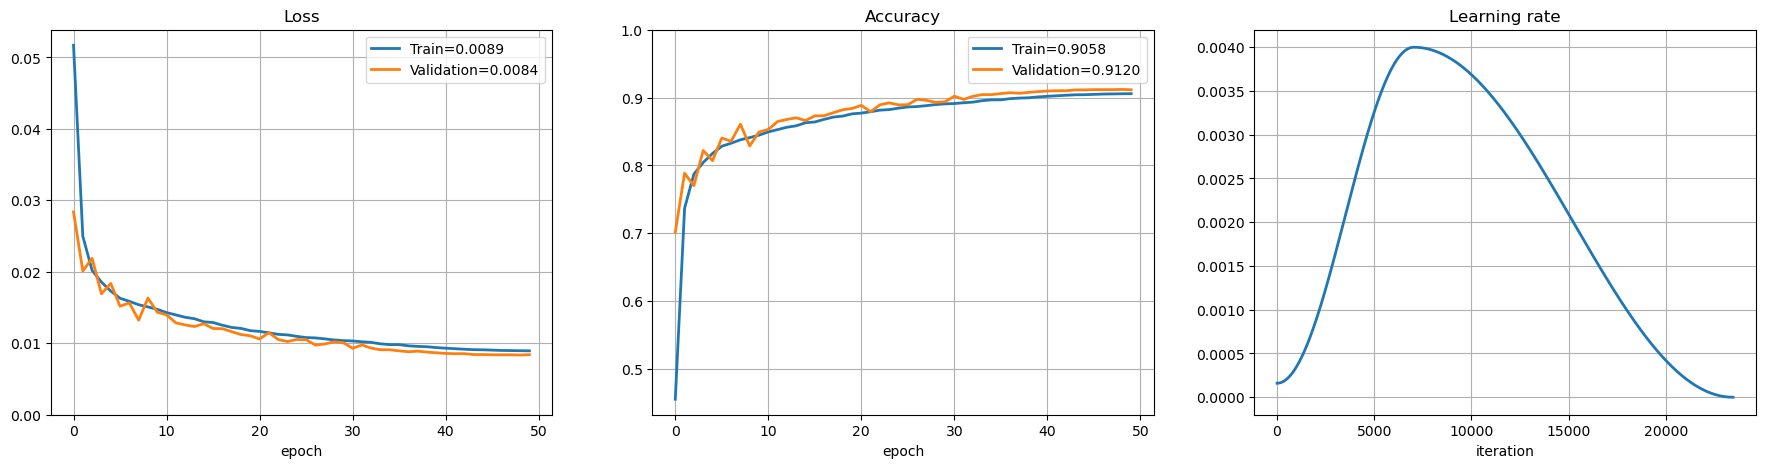

In [16]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Test the model:

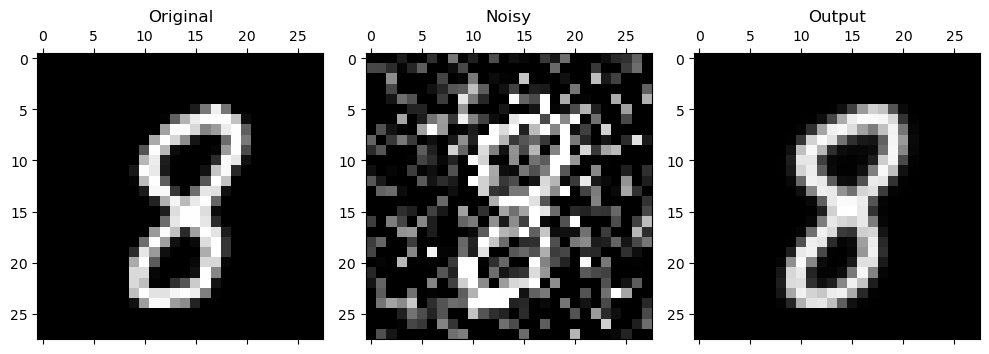

In [17]:
oModel.eval()
nTest   = len(oTestSet)
idx     = np.random.randint(nTest)
mXN, mX = oTestSet[idx]
with torch.no_grad():
    mHatX = oModel(mXN.unsqueeze(0).to(DEVICE))

_, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].matshow(mX            .squeeze(), cmap='gray'); axs[0].set_title('Original')
axs[1].matshow(mXN.clamp(0,1).squeeze(), cmap='gray'); axs[1].set_title('Noisy')
axs[2].matshow(mHatX.cpu()   .squeeze(), cmap='gray'); axs[2].set_title('Output')
plt.tight_layout()
plt.show()